In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
import random

warnings.filterwarnings('ignore')

zip_source = '/content/f1-data-2024.zip'
extract_folder = '/content/f1_data_unzipped'

if os.path.exists(zip_source):
    if not os.path.exists(extract_folder):
        with zipfile.ZipFile(zip_source, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)

base_path = extract_folder
possible_subfolder = os.path.join(extract_folder, 'f1-data-2024')
if os.path.exists(possible_subfolder):
    base_path = possible_subfolder

def parse_lap_time(time_str):
    try:
        if pd.isna(time_str): return None
        if isinstance(time_str, (int, float)): return float(time_str)
        s_str = str(time_str).strip()
        if ':' in s_str:
            parts = s_str.split(':')
            return (float(parts[0]) * 60) + float(parts[1])
        return float(s_str)
    except: return None

def format_time_display(seconds):
    if seconds is None or np.isnan(seconds): return "N/A"
    m = int(seconds // 60)
    s = seconds % 60
    return f"{m}:{s:06.3f}"

def strict_data_cleaning(df):
    df = df.sort_values(['CircuitName', 'Driver', 'LapNumber'])

    df['IsOutLap'] = df.groupby(['CircuitName', 'Driver', 'Stint']).cumcount() == 0
    df = df[~df['IsOutLap']]

    df['NextStint'] = df.groupby(['CircuitName', 'Driver'])['Stint'].shift(-1)
    df['IsInLap'] = (df['Stint'] != df['NextStint']) & (df['NextStint'].notna())
    df = df[~df['IsInLap']]

    df = df[df['LapNumber'] > 1]

    groups = df.groupby(['CircuitName', 'Driver', 'Stint'])
    keep_indices = []

    for name, group in groups:
        if len(group) < 2: continue

        times = group['TimeSec']
        Q1 = times.quantile(0.25)
        Q3 = times.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + (1.5 * IQR)

        clean_laps = group[group['TimeSec'] <= upper_bound]
        keep_indices.extend(clean_laps.index.tolist())

    return df.loc[keep_indices]

def load_data_labeled():
    all_data = []
    if not os.path.exists(base_path): return pd.DataFrame()

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".csv"):
                full_path = os.path.join(root, file)
                parts = full_path.split(os.sep)
                race_name = "Unknown"
                for p in parts:
                    if "Grand Prix" in p:
                        race_name = p
                        break
                if 'R' not in parts and 'Race' not in parts: continue

                try:
                    df = pd.read_csv(full_path)
                    if 'LapTime' not in df.columns or 'Stint' not in df.columns: continue

                    df['CircuitName'] = race_name
                    df['TimeSec'] = df['LapTime'].apply(parse_lap_time)
                    df = df.dropna(subset=['TimeSec', 'Driver', 'Compound', 'Stint'])
                    if 'TrackStatus' in df.columns: df = df[df['TrackStatus'] == 1]

                    df['TyreLife'] = df.groupby(['Driver', 'Stint']).cumcount() + 1
                    total_laps = df['LapNumber'].max()
                    df['FuelProxy'] = total_laps - df['LapNumber']

                    req_cols = ['CircuitName', 'Driver', 'LapNumber', 'Compound', 'TyreLife', 'Stint',
                                'TrackTemperature', 'AirTemperature', 'Humidity', 'FuelProxy', 'TimeSec']
                    for c in req_cols:
                        if c not in df.columns:
                            if c == 'Humidity': df[c] = 50
                            elif c == 'AirTemperature': df[c] = 25
                            elif c == 'TrackTemperature': df[c] = 35
                    all_data.append(df[req_cols])
                except Exception: continue

    if not all_data: return pd.DataFrame()
    return pd.concat(all_data, ignore_index=True)

df_raw = load_data_labeled()

if df_raw.empty:
    print("Nu s-au găsit date.")
else:
    df = strict_data_cleaning(df_raw)

    le_driver = LabelEncoder()
    df['Driver_Enc'] = le_driver.fit_transform(df['Driver'])
    le_compound = LabelEncoder()
    df['Compound_Enc'] = le_compound.fit_transform(df['Compound'])
    le_circuit = LabelEncoder()
    df['Circuit_Enc'] = le_circuit.fit_transform(df['CircuitName'])

    indices_train, indices_test = train_test_split(df.index, test_size=0.2, random_state=42)
    df.loc[indices_train, 'DatasetType'] = 'TRAIN'
    df.loc[indices_test, 'DatasetType'] = 'TEST'

    features = ['Circuit_Enc', 'Driver_Enc', 'LapNumber', 'Compound_Enc', 'TyreLife',
                'TrackTemperature', 'AirTemperature', 'Humidity', 'FuelProxy']
    target = 'TimeSec'

    X_train = df.loc[indices_train, features]
    y_train = df.loc[indices_train, target]

    model_hgbr = HistGradientBoostingRegressor(max_iter=500, learning_rate=0.05, max_depth=8,
                                               monotonic_cst=[0, 0, -1, 0, 1, 0, 0, 0, -1], random_state=42)
    model_hgbr.fit(X_train, y_train)

    model_rf = RandomForestRegressor(n_estimators=50, max_depth=12, n_jobs=-1, random_state=42)
    model_rf.fit(X_train, y_train)

    clear_output(wait=True)

    css = """
    <style>
        .main-container {
            background-color: #000000;
            padding: 20px;
            border: 3px solid #333;
            border-radius: 15px;
            font-family: 'Verdana', sans-serif;
            width: 100%;
            box-sizing: border-box;
        }

        .header {
            text-align: center;
            background: linear-gradient(90deg, #111, #222, #111);
            padding: 20px;
            border: 2px solid #00d2be;
            border-radius: 10px;
            margin-bottom: 25px;
            width: 100%;
            box-sizing: border-box;
        }

        .header h1 {
            color: #ffffff !important;
            margin: 0;
            font-weight: 900;
            text-transform: uppercase;
            letter-spacing: 1px;
            font-size: 2vw;
        }

        .widget-label {
            color: #ffffff !important;   /* TEXT ALB */
            font-size: 15px !important;
            font-weight: 900 !important;
            text-transform: uppercase;
            margin-right: 10px;
        }

        .widget-dropdown > select {
            background-color: #333 !important;
            color: #00d2be !important;   /* Culoarea selectiei */
            font-size: 16px !important;
            font-weight: bold !important;
            border: 2px solid #555 !important;
            padding: 12px !important;
            border-radius: 8px !important;
            height: 50px !important;
            width: 100% !important;
        }

        .widget-readout {
            color: #00d2be !important;
            background: transparent !important;
            font-weight: bold !important;
            font-size: 16px !important;
        }

        .result-box {
            background-color: #111;
            padding: 20px;
            border-radius: 10px;
            margin-top: 25px;
            border: 2px solid #555;
            width: 100%;
            box-sizing: border-box;
        }

        .comp-table { width: 100%; border-collapse: separate; border-spacing: 0; margin-top: 15px; }
        .comp-table th { background-color: #222; color: #00d2be; padding: 15px; text-align: left; border-bottom: 2px solid #fff; font-size: 14px; }
        .comp-table td { background-color: #111; color: #fff; padding: 15px; border-bottom: 1px solid #333; font-size: 15px; font-weight: bold; }

        .stat-card {
            background: #222;
            border: 2px solid #ff9d00;
            border-radius: 10px;
            padding: 15px;
            text-align: center;
            width: 49%;
            box-sizing: border-box;
        }
        .stat-title { color: #aaa; font-size: 14px; font-weight: bold; }
        .stat-val { color: #fff; font-size: 32px; font-weight: 900; }

        .badge-pit { background: #d500f9; color: white; padding: 10px; border-radius: 4px; font-weight: bold; border: 1px solid white; display:block; margin-top:5px; font-size: 16px;}
        .badge-clean { background: #00e676; color: black; padding: 10px; border-radius: 4px; font-weight: bold; display:block; margin-top:5px; font-size: 16px;}
        .badge-warn { background: #ffea00; color: black; padding: 10px; border-radius: 4px; font-weight: bold; display:block; margin-top:5px; font-size: 16px;}
        .badge-err { background: #ff1744; color: white; padding: 10px; border-radius: 4px; font-weight: bold; display:block; margin-top:5px; font-size: 16px;}

    </style>
    """

    circuits_list = sorted(df['CircuitName'].unique())
    drivers_list = sorted(df['Driver'].unique())
    compounds_list = sorted(df['Compound'].unique())

    style_dd = {'description_width': '150px'}
    w_race = widgets.Dropdown(options=circuits_list, description='📍 CIRCUIT:', layout=widgets.Layout(width='99%', margin='0 0 10px 0'), style=style_dd)
    w_driver = widgets.Dropdown(options=drivers_list, description='👤 PILOT:', layout=widgets.Layout(width='99%', margin='0 0 10px 0'), style=style_dd)
    w_compound = widgets.Dropdown(options=compounds_list, description='🍩 PNEU:', layout=widgets.Layout(width='99%', margin='0 0 10px 0'), style=style_dd)

    style_slider = {'description_width': '150px'}
    w_lap = widgets.IntSlider(min=2, max=70, value=10, description='🏁 TURUL:', style=style_slider, layout=widgets.Layout(width='99%'))
    w_tyrelife = widgets.IntSlider(min=1, max=50, value=5, description='📉 UZURA PNEU:', style=style_slider, layout=widgets.Layout(width='99%'))

    w_track_temp = widgets.FloatSlider(min=15, max=60, value=30, description='🌡️ TEMP. PISTA:', style=style_slider, layout=widgets.Layout(width='32.5%'))
    w_air_temp = widgets.FloatSlider(min=10, max=45, value=25, description='☁️ TEMP. AER:', style=style_slider, layout=widgets.Layout(width='32.5%'))
    w_humidity = widgets.IntSlider(min=0, max=100, value=40, description='💧 UMIDITATE %:', style=style_slider, layout=widgets.Layout(width='32.5%'))

    btn_run = widgets.Button(description="CALCULEAZĂ PREDICȚIA", button_style='warning', layout=widgets.Layout(width='100%', height='60px'))
    btn_find_test = widgets.Button(description="🎲 GĂSEȘTE TUR DE TEST (RANDOM)", button_style='primary', layout=widgets.Layout(width='100%', height='50px'))
    out_res = widgets.Output()

    def find_test_lap(b):
        subset = df_raw[df_raw['CircuitName'] == w_race.value]
        if subset.empty: subset = df_raw
        if not subset.empty:
            row = subset.sample(1).iloc[0]
            w_race.value = row['CircuitName']
            w_driver.value = row['Driver']
            w_compound.value = row['Compound']
            w_lap.value = int(row['LapNumber'])
            w_tyrelife.value = int(row['TyreLife'])
            w_track_temp.value = float(row['TrackTemperature'])
            w_air_temp.value = float(row['AirTemperature'])
            w_humidity.value = int(row['Humidity'])
            with out_res:
                clear_output()
                display(widgets.HTML(f"<div style='background:#333; color:#00d2be; padding:15px; border:2px solid #00d2be; text-align:center; font-size:16px; font-weight:bold; width:100%; box-sizing:border-box;'>✅ DATA ÎNCĂRCATĂ: {row['Driver']} - Turul {row['LapNumber']}</div>"))

    def on_predict(b):
        with out_res:
            clear_output()
            try:
                c_enc = le_circuit.transform([w_race.value])[0]
                d_enc = le_driver.transform([w_driver.value])[0]
                cmp_enc = le_compound.transform([w_compound.value])[0]
                max_laps = df[df['CircuitName'] == w_race.value]['LapNumber'].max()
                fuel = max_laps - w_lap.value

                input_data = [[c_enc, d_enc, w_lap.value, cmp_enc, w_tyrelife.value,
                               w_track_temp.value, w_air_temp.value, w_humidity.value, fuel]]

                p_hgbr = model_hgbr.predict(input_data)[0]
                p_rf = model_rf.predict(input_data)[0]

                real_row = df_raw[(df_raw['CircuitName'] == w_race.value) &
                                  (df_raw['Driver'] == w_driver.value) &
                                  (df_raw['LapNumber'] == w_lap.value)]

                is_pitting_next = False
                next_lap_row = df_raw[(df_raw['CircuitName'] == w_race.value) &
                                      (df_raw['Driver'] == w_driver.value) &
                                      (df_raw['LapNumber'] == w_lap.value + 1)]
                if not real_row.empty and not next_lap_row.empty:
                    if real_row.iloc[0]['Stint'] != next_lap_row.iloc[0]['Stint']:
                        is_pitting_next = True

                real_time_str = "---"
                diff_hgbr_str = "-"
                diff_rf_str = "-"
                diag_msg = "<span style='color:#777'>SIMULARE</span>"

                if not real_row.empty:
                    rt = real_row.iloc[0]['TimeSec']
                    real_time_str = format_time_display(rt)
                    d_hgbr = rt - p_hgbr
                    d_rf = rt - p_rf

                    def fmt_diff(val):
                        c = "#ff5252" if val > 0 else "#69f0ae"
                        return f"<span style='color:{c}; font-weight:900; font-size:18px'>{val:+.3f}s</span>"

                    diff_hgbr_str = fmt_diff(d_hgbr)
                    diff_rf_str = fmt_diff(d_rf)

                    if is_pitting_next:
                        if d_hgbr < -0.2: diag_msg = "<span class='badge-pit'>🚨 BOX PUSH (URMEAZĂ PIT STOP)<br>Pilotul a tras tare.</span>"
                        elif d_hgbr > 0.5: diag_msg = "<span class='badge-pit'>🚨 DEAD TIRES (URMEAZĂ PIT STOP)<br>Pneuri terminate.</span>"
                        else: diag_msg = "<span class='badge-pit'>🚨 NORMAL IN-LAP (URMEAZĂ PIT STOP)</span>"
                    else:
                        if d_hgbr > 1.0: diag_msg = "<span class='badge-err'>⚠️ TRAFIC / EROARE</span>"
                        elif d_hgbr > 0.3: diag_msg = "<span class='badge-warn'>🐢 RITM SLAB / UZURĂ</span>"
                        elif d_hgbr < -0.3: diag_msg = "<span class='badge-clean'>🚀 TUR FOARTE RAPID</span>"
                        else: diag_msg = "<span class='badge-clean'>✅ TUR CURAT (PREDICȚIE EXACTĂ)</span>"

                html = f"""
                <div class='result-box'>
                    <div style='display:flex; justify-content:space-between; margin-bottom:20px;'>
                        <div class='stat-card'>
                            <div class='stat-title'>TIMP REAL</div>
                            <div class='stat-val' style='color:#ff9d00'>{real_time_str}</div>
                        </div>
                        <div class='stat-card'>
                            <div class='stat-title'>PREDICȚIE AI</div>
                            <div class='stat-val' style='color:#fff'>{format_time_display(p_hgbr)}</div>
                        </div>
                    </div>

                    <div style='text-align:center; padding:10px; border:1px dashed #555; border-radius:8px;'>
                        <div style='color:#aaa; font-size:12px; font-weight:bold;'>DIAGNOSTIC INTELIGENT</div>
                        {diag_msg}
                    </div>

                    <table class='comp-table'>
                        <thead><tr><th>MODEL</th><th>ESTIMARE</th><th>DIFERENȚĂ</th></tr></thead>
                        <tbody>
                            <tr><td>Gradient Boosting</td><td>{format_time_display(p_hgbr)}</td><td>{diff_hgbr_str}</td></tr>
                            <tr><td>Random Forest</td><td>{format_time_display(p_rf)}</td><td>{diff_rf_str}</td></tr>
                        </tbody>
                    </table>
                </div>
                """
                display(widgets.HTML(html))
            except Exception as e: print(f"Eroare: {e}")

    btn_run.on_click(on_predict)
    btn_find_test.on_click(find_test_lap)

    ui = widgets.VBox([
        widgets.HTML(f"{css}<div class='header'><h1>🏎️ F1 STRATEGY DASHBOARD</h1></div>"),
        btn_find_test, widgets.HTML("<div style='height:20px'></div>"),
        w_race, w_driver, w_compound,
        widgets.HTML("<hr style='border:1px solid #333; margin:15px 0;'>"),
        widgets.VBox([w_lap, w_tyrelife]),
        widgets.HTML("<hr style='border:1px solid #333; margin:15px 0;'>"),
        widgets.HBox([w_track_temp, w_air_temp, w_humidity]),
        widgets.HTML("<div style='height:25px'></div>"), btn_run, out_res
    ])
    ui.add_class("main-container")
    display(ui)

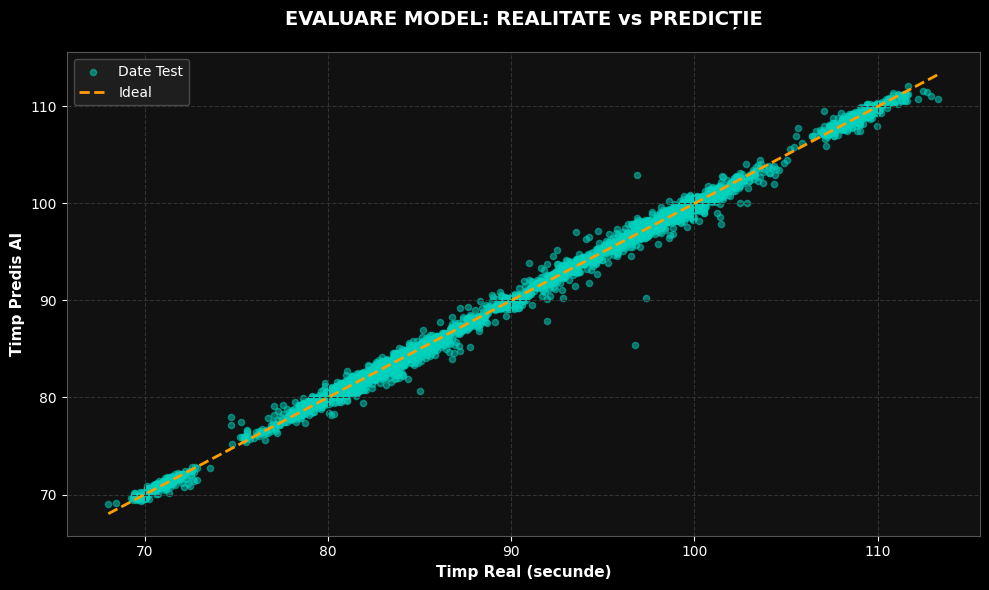

In [ ]:

import matplotlib.pyplot as plt

plt.style.use('dark_background')

X_test_plot = df.loc[indices_test, features]
y_test_plot = df.loc[indices_test, target]
preds_plot = model_hgbr.predict(X_test_plot)

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#000000')
ax.set_facecolor('#111111')

ax.scatter(y_test_plot, preds_plot, alpha=0.5, color='#00d2be', s=20, label='Date Test')

min_val = min(y_test_plot.min(), preds_plot.min())
max_val = max(y_test_plot.max(), preds_plot.max())
ax.plot([min_val, max_val], [min_val, max_val], color='#ff9d00', linestyle='--', linewidth=2, label='Ideal')

ax.set_xlabel('Timp Real (secunde)', color='white', fontsize=11, fontweight='bold')
ax.set_ylabel('Timp Predis AI', color='white', fontsize=11, fontweight='bold')
ax.set_title('EVALUARE MODEL: REALITATE vs PREDICȚIE', color='white', fontsize=14, fontweight='bold', pad=20)

ax.grid(True, color='#333333', linestyle='--')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('#555555')

plt.legend(facecolor='#222', edgecolor='#555', labelcolor='white')
plt.tight_layout()
plt.show()